# Cross Validation Framework

#### Veri setinin hazırlanması

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

#### Veri seti sklearn içinde hazır, bunu DESCR ile inceleyebiliriz

In [2]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

#### Veriye ön bakış

In [6]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


#### Daha anlamlı analiz için
Gelecekteki görselleştirmeyi basitleştirmek için fiyatları 100 (k$) aralığından bin dolar (k$) aralığına dönüştürelim.

In [5]:
target *= 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

#### Modelin uygulanması

In [7]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

DecisionTreeRegressor(random_state=0)

#### Generilization Performansı
Genelleme performansını bulmak amacıyla bize yerel birimde bir hata, yani k$ veren ortalama mutlak hatayı kullanırız.

Hatasız mükemmel tahmin elde ederiz. Çok iyimser ve makine öğrenimi yaparken neredeyse her zaman metodolojik bir sorunu açığa çıkarıyor.

Gerçekten de, aynı veri kümesi üzerinde eğitim aldık ve tahminde bulunduk. Karar ağacımız tamamen büyüdüğünden, veri kümesindeki her örnek bir yaprak düğümde saklanır. Bu nedenle, karar ağacımız fit sırasında verilen veri setini tamamen ezberledi ve bu nedenle tahmin yaparken hata yapmadı.

Yukarıda hesaplanan bu hataya ampirik hata veya eğitim hatası denir.

In [8]:
from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


#### Ampirik (eğitim) hatasını çözüm önerileri
veri setimizi iki alt kümeye bölmek: bir eğitim seti ve bir test seti;

modeli eğitim setine yerleştirme;

eğitim setindeki eğitim hatasının tahmin edilmesi;

test setindeki test hatasının tahmin edilmesi.

**NOT:** Test hatası aslında bir üretim ortamında kullanılmış olsaydı modelimizden ne bekleyeceğimizle ilgili.

In [9]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)
regressor.fit(data_train, target_train)

target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"The training error of our model is {score:.2f} k$")

target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"The testing error of our model is {score:.2f} k$")

The training error of our model is 0.00 k$
The testing error of our model is 47.28 k$


#### ShuffleSplit

Tek bir tren testi bölümü yaparken, tahmine dayalı modelimizin değerlendirmesinin sağlamlığına ilişkin herhangi bir belirti vermiyoruz: özellikle, test seti küçükse, bu test hatası tahmini kararsız olacaktır ve yansıtmaz. aynı modelle sınırsız miktarda test verisi üzerinde gözlemleyeceğimiz "gerçek hata oranı".

Örneğin, sınırlı veri kümemizi rastgele böldüğümüzde ve test kümesinde tahmin etmesi en kolay durumlardan bazılarını şans eseri izole ettiğimizde şanslı olabilirdik: bu durumda test hatasının tahmini aşırı iyimser olurdu.

Çapraz doğrulama, bölme prosedürünü tekrarlayarak tahmine dayalı bir modelin sağlamlığının tahmin edilmesini sağlar. Birkaç eğitim ve test hatası verecek ve böylece model genelleştirme performansının değişkenliğine ilişkin bazı tahminler verecektir.

Farklı çapraz doğrulama stratejileri vardır, şimdilik "karıştır-böl" adı verilen stratejiye odaklanacağız. Bu stratejinin her yinelemesinde biz:

     tam veri kümesinin bir kopyasının örneklerinin sırasını rastgele karıştırın;
     karıştırılmış veri setini bir tren ve bir test setine ayırın;
     tren setinde yeni bir model eğitin;
     test setindeki test hatasını değerlendirin.

Bu prosedürü n_splits kez tekrarlıyoruz. Hesaplama maliyetinin n_splits ile arttığını unutmayın.

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error")

In [11]:
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.133763,0.002690,-46.909797
1,0.132678,0.002730,-46.421170
2,0.133460,0.004049,-47.411089
3,0.131422,0.002664,-44.319824
4,0.145930,0.002566,-47.607875


In [12]:
cv_results["test_error"] = -cv_results["test_score"]

In [13]:
cv_results.head(10)

,fit_time,score_time,test_score,test_error
0,0.133763,0.002690,-46.909797,46.909797
1,0.132678,0.002730,-46.421170,46.421170
2,0.133460,0.004049,-47.411089,47.411089
3,0.131422,0.002664,-44.319824,44.319824
4,0.145930,0.002566,-47.607875,47.607875
5,0.148523,0.003415,-45.901300,45.901300
6,0.158282,0.003745,-46.572767,46.572767
7,0.133198,0.003064,-46.194585,46.194585
8,0.132538,0.003407,-45.590236,45.590236
9,0.155315,0.003272,-45.727998,45.727998


In [14]:
len(cv_results)

40

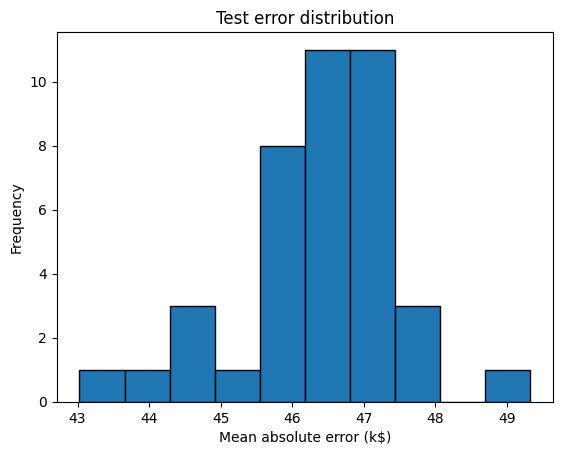

In [15]:
import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")